# Identifying Volume and Volume Uncertainty of a Pit

## 0. Introduction

#### Objectives
Our primary objectives are as follows:
1. Identify the boundary of an ablated pit 
2. Measure its volume
3. Quantify volume uncertainty

#### The Catch
Our pit has been made on an imperfect natural surface and the post-ablation shape of the surface has been measured imperfectly too. These imperfections introduce two uncertainties in quantifying pit volume and associated uncertainty: 
1. Natural surface roughness
2. Measurement uncertainty

If we assume that the sample surface is ideally planar, then topographic variance away from the best-fit plane is described as a sum of surface roughness and measurement uncertainty. Quantifying this variance is the key to quanitifying volume uncertainty of the ablated pit.

## 1. Quantifying Surface Topographic Variance
First, we load the test surface data, which is an x,y,z tab-separated values list of surface coordinates. These data come from Barb Cohen (Feb 1, 2021 to Jacob).


In [29]:
import numpy as np

data = np.loadtxt('surface.tsv')
print('%d coordinate triplets loaded' % len(data))

X = data[:,0]
Y = data[:,1]
Z = data[:,2]

7191 coordinate triplets loaded


**Now plot the data points**

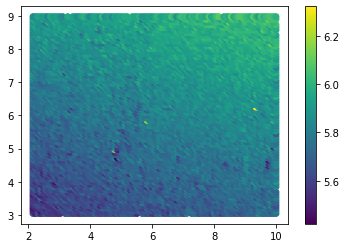

In [30]:
import matplotlib.pyplot as plt

plt.scatter(X,Y,c=Z)
plt.colorbar()
plt.show()

**The surface topography grades across the map**. We reduce this by fitting a plane to the data and subtracting this from the data.

To model a plane we will compute the least squares solution to Ax=b where A is the coordinate matrix and b is the surface height matrix.

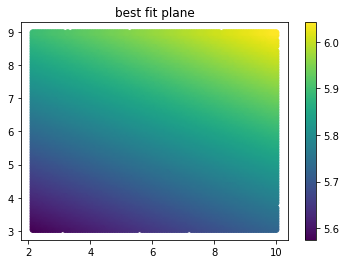

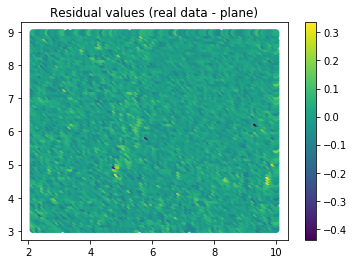

In [31]:
import scipy.linalg as la

#First Concatenate the left side of the equation (Ax)
A = np.c_[X,Y,np.ones(len(data))]

#perform least squares inversion, keep the coefficients, ignore 3 other outputs
Coeffs,_,_,_ = la.lstsq(A,Z)

#Check it on the same coordinates
Z_plane = Coeffs[0]*X + Coeffs[1]*Y + Coeffs[2]
Z_residual = Z_plane - Z

plt.clf()
plt.scatter(X,Y,c=Z_plane)
plt.colorbar()
plt.title('best fit plane')
plt.show()

plt.clf()
plt.scatter(X,Y,c=Z_residual)
plt.colorbar()
plt.title('Residual values (real data - plane)')
plt.show()

**Statistics can now be performed to characterize the topographic variance**
Additionally, we can draw a profile to see the variance of the data

The mean residual value should be close to 0. In reality, it is:   0.000000
The standard deviation of the residual is: 0.045715
90%, 95%, and 99% of the residual lies within: 0.072237, 0.090241, 0.128833 of the mean value


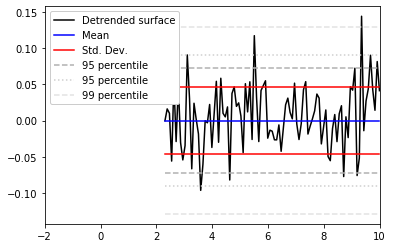

In [32]:
resid_mean = np.mean(Z_residual)
resid_std =  np.std(Z_residual)
abs_resid_90 = np.percentile(np.abs(Z_residual),90)
abs_resid_95 = np.percentile(np.abs(Z_residual),95)
abs_resid_99 = np.percentile(np.abs(Z_residual),99)

print("The mean residual value should be close to 0. In reality, it is:   %0.6f" % resid_mean)
print("The standard deviation of the residual is: %0.6f" % resid_std)
print("90%%, 95%%, and 99%% of the residual lies within: %0.6f, %0.6f, %0.6f of the mean value" % (abs_resid_90, \
                                                                                               abs_resid_95, \
                                                                                               abs_resid_99))

#Lets plot this all up along with a data profile across the center of the plotted data above
profile_Z = Z_residual[np.where(Y==np.median(Y))]
profile_X = X[np.where(Y==np.median(Y))]
prof_mean = np.ones(len(profile_Z))*resid_mean
tprof_std = np.ones(len(profile_Z))*resid_std   + resid_mean 
tprof_90 = np.ones(len(profile_Z))*abs_resid_90 + resid_mean 
tprof_95 = np.ones(len(profile_Z))*abs_resid_95 + resid_mean 
tprof_99 = np.ones(len(profile_Z))*abs_resid_99 + resid_mean 
bprof_std = np.ones(len(profile_Z))*-1*resid_std   + resid_mean 
bprof_90 = np.ones(len(profile_Z))*-1*abs_resid_90 + resid_mean 
bprof_95 = np.ones(len(profile_Z))*-1*abs_resid_95 + resid_mean 
bprof_99 = np.ones(len(profile_Z))*-1*abs_resid_99 + resid_mean 

plt.plot(profile_X,profile_Z,c='k',label='Detrended surface')
plt.plot(profile_X,prof_mean,c='b',label='Mean')
plt.plot(profile_X,tprof_std,c='r',label='Std. Dev.')
plt.plot(profile_X,tprof_90,c='80',ls='dashed')
plt.plot(profile_X,tprof_95,c='50',ls='dotted')
plt.plot(profile_X,tprof_99,c='30',ls='dashed')
plt.plot(profile_X,bprof_std,c='r')
plt.plot(profile_X,bprof_90,c='80',ls='dashed',label='95 percentile')
plt.plot(profile_X,bprof_95,c='50',ls='dotted',label='95 percentile')
plt.plot(profile_X,bprof_99,c='30',ls='dashed',label='99 percentile')
plt.legend(loc='upper left',framealpha=1)
plt.xlim([-2,10]) #to show both data and legend
plt.show()

## 2. Uncertainty Propagation

Variance at any coordinate considered to be independent and normally distributed (e.g., random along a gaussian distribution). The mean and standard deviation that describe the normal distribution are calculated in the previous step. 

*Here we will accept the standard deviation as the intrinsic uncertainty of the data, which is a combination of surface roughness and measurement uncertainty*

#### If an entire region of the detrended surface is assumed to have a constant mean elevation, what is the expected volume error?

**Volume = Area x Height**

In this case, Area is the product of the x and y spacing and Height is the integrated elevation of coordinate triplet.

**Volume Uncertainty = Area x Total Height Uncertainty**

Uncertainty from adding independent quantities propogates as a quadrature sum. This is explored with the profile data from the above chart

In [33]:
x_step = 0.0801
y_step = 0.0801

x_cells = len(profile_Z)
y_cells = 1

total_cells = x_cells*y_cells

#Make an array, the same size as the cells in question, and make all array values = the standard deviation
single_cell_uncertainties = np.ones(total_cells) * resid_std

#Add these uncertantites in quadrature 
height_uncertainty = np.sum(single_cell_uncertainties**2)**0.5

#Multiply the height uncertainty by the grid cell area to get volume
volume_uncertainty = x_step * y_step * height_uncertainty

print('Over the %d cells in the profile, total volume uncertainty is +/- %0.6f cu. units.' % (total_cells,volume_uncertainty))

Over the 94 cells in the profile, total volume uncertainty is +/- 0.002844 cu. units.


### Results

While the actual error won't be exactly equivalent to the estimated uncertainty, the actual error should be within the estimated uncertainty (i.e., <100%) about 68% of the time, assuming the uncertainties really are normally distributed. By extension, the data should be within 200% of the estimated uncertainty 95% of the time, representing the 2-standard deviation threshold.

In [34]:
volume_expected = x_step* y_step * total_cells * resid_mean
print('The expected volume over the profile subsample, assuming a mean elevation is: %0.6f cu. units' % volume_expected)

volume_observed = x_step * y_step * np.sum(profile_Z)
print('The observed volume of the subsample is: %0.6f cu. units' % volume_observed)

volume_error_comparison = abs(volume_observed - volume_expected)/volume_uncertainty
print('The actual error is %0.3f%% of the estimated uncertainty' % (volume_error_comparison*100))

The expected volume over the profile subsample, assuming a mean elevation is: 0.000000 cu. units
The observed volume of the subsample is: 0.003786 cu. units
The actual error is 133.151% of the estimated uncertainty


## 3. Identifying a pit

OpenCV can be used to identify a pit on a regular gridded raster dataset

A pit can be defined as a contiguous collection of points that are below (by some threshold, perhaps 1 sigma) below the mean value

### To be continued...